<a href="https://www.kaggle.com/code/khinguyntin/object-detection?scriptVersionId=260416441" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Install ultralytics for YOLO training and inference

In [5]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.9 MB/s eta 0:00:0000:01m0:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 6.2 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found exi

# Data reformatting

**Split data into train and val in YOLO format**

Function to handle transforming bbox coordinates to YOLO format and splitting train folder to training and validating set

In [ ]:
import os
import shutil
import random
from PIL import Image

def process_and_split_data(
    base_source_dir, 
    base_target_dir, 
    val_split=0.2, 
    splits_to_include=['Train', 'Test'] # Original dataset folders to pull from
):
    """
    Consolidates image-label pairs, splits them into train/val, and converts
    labels to YOLO format (normalized x_center y_center width height).

    Args:
        base_source_dir (str): Root directory of your original competition data.
                                E.g., 'COMPETITIONS/2425II_AIT3002_2-Object-Detection/Dataset'
                                This should contain 'Train' and 'Test' sub-folders.
        base_target_dir (str): Root directory where the new YOLO-formatted
                                dataset will be created.
                                E.g., 'COMPETITIONS/2425II_AIT3002_2-Object-Detection/Dataset/yolo_final_dataset'
        val_split (float): Proportion of data to use for validation.
        splits_to_include (list): List of original sub-folders (e.g., 'Train', 'Test')
                                  to include in the consolidated dataset.
    """

    all_image_label_pairs = []

    # 1. Collect all image-label pairs from specified source splits
    print(f"Collecting data from: {splits_to_include} folders in {base_source_dir}")
    for split_name in splits_to_include:
        img_dir = os.path.join(base_source_dir, split_name, 'images')
        label_dir = os.path.join(base_source_dir, split_name, 'labels')

        if not os.path.exists(img_dir) or not os.path.exists(label_dir):
            print(f"Warning: '{split_name}' images or labels directory not found. Skipping {split_name}.")
            continue

        image_filenames = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        
        for img_filename in image_filenames:
            base_name = os.path.splitext(img_filename)[0]
            label_filename = base_name + '.txt'
            img_path = os.path.join(img_dir, img_filename)
            label_path = os.path.join(label_dir, label_filename)

            if os.path.exists(label_path):
                all_image_label_pairs.append((img_path, label_path))
            else:
                print(f"Warning: No label file found for {img_filename} at {label_path}. Skipping.")

    if not all_image_label_pairs:
        raise RuntimeError(f"No valid image-label pairs found in {base_source_dir}/{splits_to_include}")

    print(f"Total valid image-label pairs collected: {len(all_image_label_pairs)}")

    # 2. Shuffle and split the collected data
    random.shuffle(all_image_label_pairs)
    num_val_samples = int(len(all_image_label_pairs) * val_split)
    
    val_pairs = all_image_label_pairs[:num_val_samples]
    train_pairs = all_image_label_pairs[num_val_samples:]

    print(f"Splitting into {len(train_pairs)} training and {len(val_pairs)} validation samples.")

    # 3. Create target directories
    for sub_dir in ['images', 'labels']:
        os.makedirs(os.path.join(base_target_dir, sub_dir, 'train'), exist_ok=True)
        os.makedirs(os.path.join(base_target_dir, sub_dir, 'val'), exist_ok=True)
        # os.makedirs(os.path.join(base_target_dir, sub_dir, 'test'), exist_ok=True) # If you want a separate test set

    # 4. Process and copy files to target directories
    print("\nProcessing and copying files to new structure...")

    def process_pair(img_src_path, label_src_path, target_img_dir, target_label_dir):
        try:
            # Get image dimensions
            with Image.open(img_src_path) as img:
                img_width, img_height = img.size
            
            # Read original label and convert
            converted_lines = []
            with open(label_src_path, 'r') as f_in:
                for line in f_in:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id = int(parts[0])
                        x_min, y_min, x_max, y_max = map(float, parts[1:])

                        # Validate raw coordinates
                        if not (0 <= x_min < x_max <= img_width + 1e-6 and 0 <= y_min < y_max <= img_height + 1e-6): # added small epsilon for float comparison
                            # print(f"Skipping malformed box (out of bounds) in {os.path.basename(label_src_path)}: {line.strip()}")
                            continue

                        # Convert to YOLO format
                        x_center = (x_min + x_max) / 2
                        y_center = (y_min + y_max) / 2
                        box_width = x_max - x_min
                        box_height = y_max - y_min

                        # Normalize
                        x_norm_center = x_center / img_width
                        y_norm_center = y_center / img_height
                        norm_width = box_width / img_width
                        norm_height = box_height / img_height

                        # Validate normalized coordinates (should be [0,1])
                        # Small adjustments for floating point inaccuracies near 0 or 1
                        x_norm_center = max(0.0, min(1.0, x_norm_center))
                        y_norm_center = max(0.0, min(1.0, y_norm_center))
                        norm_width = max(0.0, min(1.0, norm_width))
                        norm_height = max(0.0, min(1.0, norm_height))
                        
                        # A box with zero width or height is usually invalid for YOLO
                        if norm_width == 0 or norm_height == 0:
                            # print(f"Skipping malformed box (zero dimension) in {os.path.basename(label_src_path)}: {line.strip()}")
                            continue

                        converted_lines.append(
                            f"{class_id} {x_norm_center:.6f} {y_norm_center:.6f} {norm_width:.6f} {norm_height:.6f}"
                        )
                    else:
                        print(f"Skipping malformed line (wrong parts count) in {os.path.basename(label_src_path)}: {line.strip()}")

            # Save converted label file
            target_label_path = os.path.join(target_label_dir, os.path.basename(label_src_path))
            with open(target_label_path, 'w') as f_out:
                for converted_line in converted_lines:
                    f_out.write(converted_line + '\n')
            
            # Copy image file
            target_img_path = os.path.join(target_img_dir, os.path.basename(img_src_path))
            shutil.copy(img_src_path, target_img_path)

        except FileNotFoundError:
            print(f"Error: Missing file (image or label) while processing {img_src_path}. Skipping.")
        except Exception as e:
            print(f"Error processing {img_src_path} and {label_src_path}: {e}. Skipping this pair.")


    # Process train pairs
    for i, (img_path, label_path) in enumerate(train_pairs):
        process_pair(
            img_path, 
            label_path, 
            os.path.join(base_target_dir, 'images', 'train'),
            os.path.join(base_target_dir, 'labels', 'train')
        )
        if (i + 1) % 1000 == 0:
            print(f"Processed {i+1}/{len(train_pairs)} training samples.")

    # Process val pairs
    for i, (img_path, label_path) in enumerate(val_pairs):
        process_pair(
            img_path, 
            label_path, 
            os.path.join(base_target_dir, 'images', 'val'),
            os.path.join(base_target_dir, 'labels', 'val')
        )
        if (i + 1) % 1000 == 0:
            print(f"Processed {i+1}/{len(val_pairs)} validation samples.")

    print("\nDataset preparation complete!")
    print(f"New YOLO-formatted dataset structure created at: {base_target_dir}")

Doing transforming and splitting

In [ ]:
original_dataset_root = '/kaggle/input/2425-ii-ait-3002-2-object-detection/Dataset'

# This is where the final, YOLO-formatted dataset will be created
# It will contain 'images/train', 'images/val', 'labels/train', 'labels/val'
final_yolo_dataset_root = '/kaggle/working/structured_data'

    # Run the combined processing and splitting
process_and_split_data(
        base_source_dir=original_dataset_root,
        base_target_dir=final_yolo_dataset_root,
        val_split=0.2, # 20% of the combined data for validation
        splits_to_include=['Train', 'Test'] # Include both original 'Train' and 'Test' data
                                          # If 'Test' labels are not reliable for training,
                                          # remove 'Test' from this list.
    )

# Training model YOLO12X

**YOLO12x is the largest version of latest YOLO model, which surpassed YOLO11x by 0.7 on mAP0.5-0.95**

I set up training on gpu A100 80 GB for 400 epochs, it took 15hrs to complete with YOLO12x

For other experiment, I tried:
1. Training YOLO11 from scratch for 400 epochs, 
2. Finetuning YOLO11 pretrained for 400 epochs, 
3. Fintuning detr(resnet50) for 50 epochs,
4. And infer (DINO+gemma) as one shot object detection.

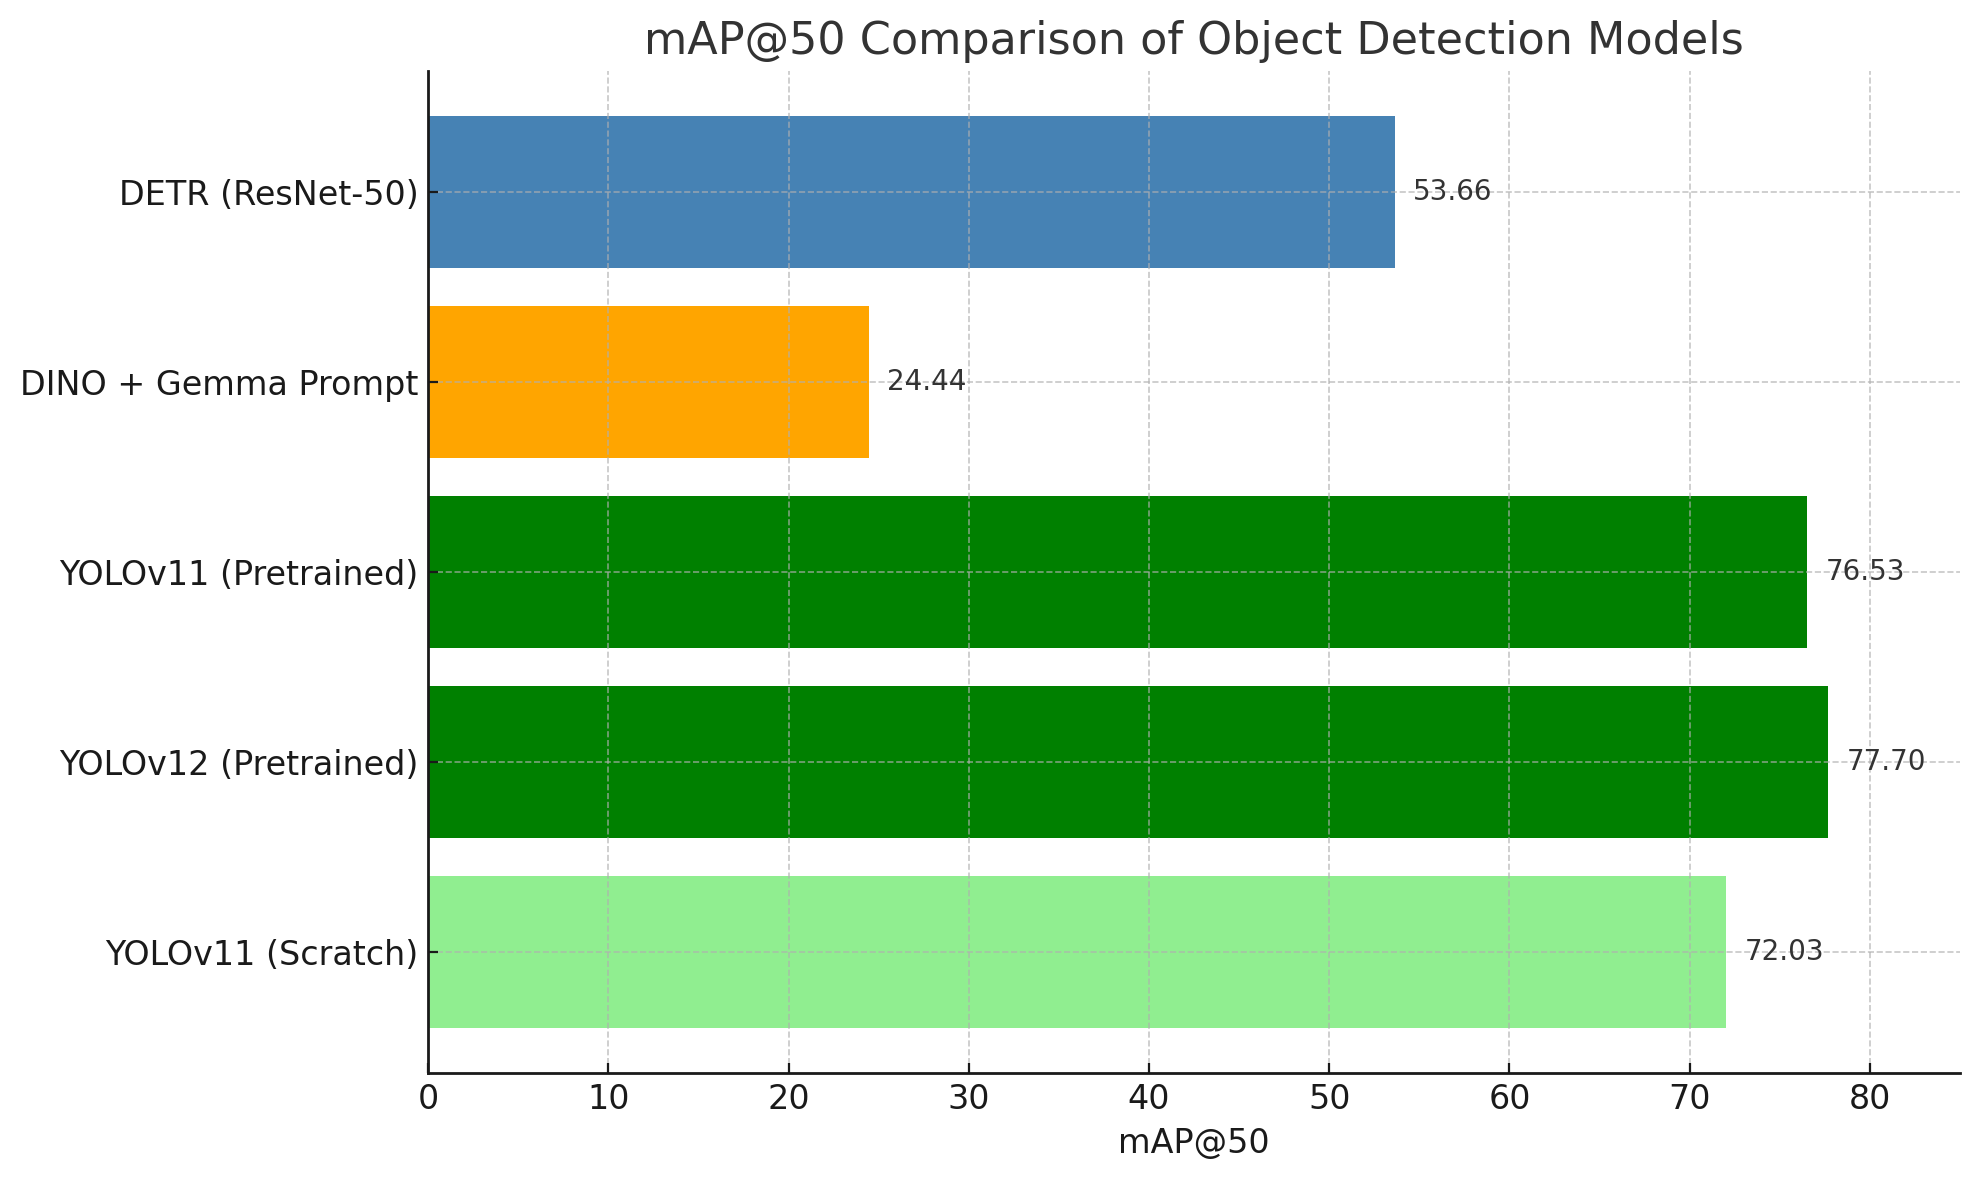
With YOLO11 trained from scratch, mAP on test is 0.72, the pretrained version achive 0.76 with same epoch training, the YOLO12 is slightly better at 0.77. The detr is a pretrained version called with huggingface transformer, it only achieve 0.53, yet I only trained it for 50 epochs. I also tried one shot prompt with DINO, and enhance the prompt using Gemma model to label fruits in image, however, may this model still needs to be finetuned.  
All experiment is infered with confidence threshold of 0.25.
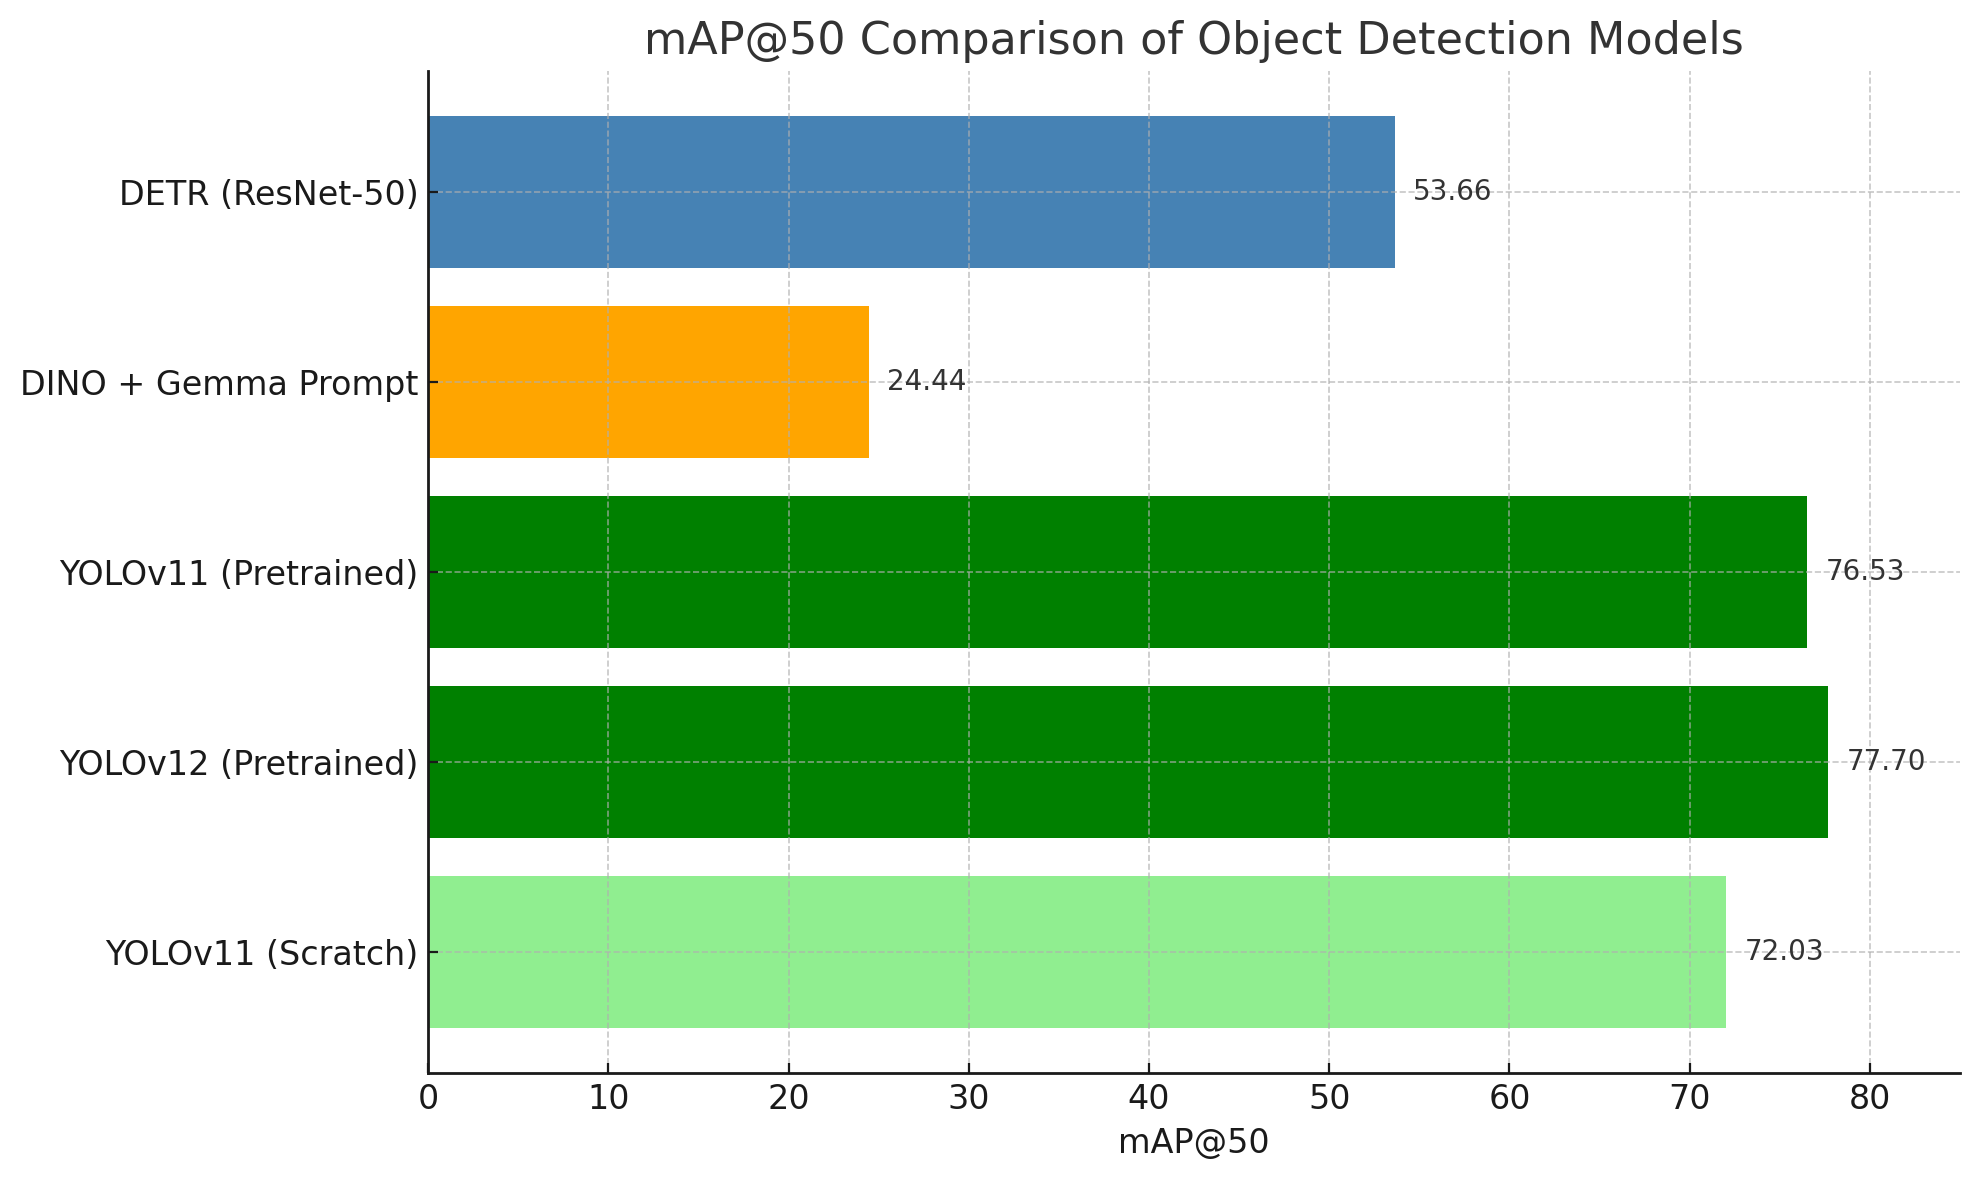

In [ ]:
from ultralytics import YOLO

# Load YOLOv12x model (replace with correct path to .pt if custom)
model = YOLO('yolo12x.pt')  

# Train the model
results = model.train(
    data='/kaggle/input/data-path/config.yaml',  # Path to dataset config
    epochs=400,                     #moderate epoch for pretrain
    imgsz=640,                      # Image size
    batch=32,                       # Batch size
    patience=100,                    # Early stopping patience
    lr0=0.0001,                     # Initial learning rate
    optimizer='Adam',              # Optimizer
    weight_decay=0.0005,           # L2 regularization
    device='0,1',                  # Multi-GPU training on GPU 0 and 1 for T4 GPU kaggle, I used cuda for training on one A100
    augment=True,                  # Use data augmentation
    cos_lr=True,                   # Cosine LR scheduler
    name='yolov12x_runs'           # Custom run name
)

print("Training complete!")

In [ ]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

# Inference

This code create a csv file contains the prediction of finetuned YOLO12x on test set, the final result is achieved with lowering the confidence to 0.05

In [2]:
import os
import torch
import pandas as pd
from ultralytics import YOLO
import numpy as np 
import json # Import the json module
import csv  # Import csv module for quoting options

def infer_and_create_dataframe(
    model_path, 
    test_image_folder, 
    imgsz=640, 
    conf_threshold=0.05, 
    iou_threshold=0.7, 
    device=None
):
    """
    Performs inference on a folder of images and returns a Pandas DataFrame
    with image IDs and detected bounding boxes in pixel coordinates.

    Args:
        model_path (str): Path to your trained YOLOv8 model weights (.pt file).
        test_image_folder (str): Path to the folder containing your test images.
        imgsz (int, optional): Input image size for the model. Defaults to 640.
        conf_threshold (float, optional): Confidence threshold for detections.
                                         Only detections with confidence > this are kept.
                                         Defaults to 0.25.
        iou_threshold (float, optional): IoU threshold for Non-Maximum Suppression (NMS).
                                         Defaults to 0.7.
        device (str, optional): Device to run inference on ('cpu', '0', '1', etc.).
                                Defaults to None (auto-detect, usually GPU if available).

    Returns:
        pd.DataFrame: A DataFrame with 'ID' (image filename) and 'bounding_boxes' columns.
                      'bounding_boxes' is a list of dicts, each dict contains:
                      {'class_id', 'confidence', 'x_min', 'y_min', 'x_max', 'y_max'}
    """

    print(f"Loading model from: {model_path}")
    model = YOLO(model_path)

    if device is None:
        device = '0' if torch.cuda.is_available() else 'cpu'
    print(f"Running inference on device: {device}")

    # Initialize a list to store data for DataFrame rows
    dataframe_rows = []

    # Run inference on the test image folder
    print(f"Starting inference on images in: {test_image_folder}")
    results = model.predict(
        source=test_image_folder,
        imgsz=imgsz,
        conf=conf_threshold,
        iou=iou_threshold,
        device=device,
        augment=True,
        verbose=False 
    )

    print("\nProcessing results and creating DataFrame...")
    
    #sequential_id_counter = 1 # Initialize sequential ID counter

    for result in results:
        image_path = result.path # This is the full path to the original image file

        # OLD LINE (this was the problem):
        # image_id = "img" + str(sequential_id_counter) 
        # sequential_id_counter += 1 

        # NEW LINE (THIS IS THE CORRECT FIX):
        image_id = os.path.splitext(os.path.basename(image_path))[0]
        #image_id = "img" + str(sequential_id_counter) # Your sequential ID
        #sequential_id_counter += 1 

        image_bounding_boxes = []
        
        if result.boxes is not None and len(result.boxes) > 0:
            boxes_xyxy = result.boxes.xyxy.cpu().numpy()
            confs = result.boxes.conf.cpu().numpy()
            class_ids = result.boxes.cls.cpu().numpy()

            for i in range(len(boxes_xyxy)):
                x_min, y_min, x_max, y_max = boxes_xyxy[i]
                conf = confs[i]
                cls_id = int(class_ids[i])

                image_bounding_boxes.append({
                    'class_id': cls_id, # Changed 'class' to 'class_id' for consistency with dict key
                    'confidence': float(conf), 
                    'x_min': float(x_min),
                    'y_min': float(y_min),
                    'x_max': float(x_max),
                    'y_max': float(y_max)
                })
        
        dataframe_rows.append({
            'image_id': image_id,
            'bounding_boxes': image_bounding_boxes
        })
        
        # Corrected print statement to show the sequential ID
        #print(f"  Processed {image_id}: {len(image_bounding_boxes)} detections.")

    df = pd.DataFrame(dataframe_rows)
    print("\nDataFrame creation complete!")
    return df

# --- Example Usage ---
if __name__ == "__main__":
    # IMPORTANT: Adjust these paths to your specific environment
    
    model_weights_path = '/kaggle/input/yolo12x/pytorch/default/2/yolo12_best.pt'
    test_images_folder = '/kaggle/input/2425-ii-ait-3002-2-object-detection/Dataset/Test/images'
    output_csv_filename = 'submission.csv' # Name of your output CSV file

    if not os.path.exists(model_weights_path):
        print(f"Error: Model weights not found at {model_weights_path}")
        exit()
    if not os.path.exists(test_images_folder):
        print(f"Error: Test image folder not found at {test_images_folder}")
        exit()

    predictions_df = infer_and_create_dataframe(
        model_path=model_weights_path,
        test_image_folder=test_images_folder,
        imgsz=640,
        conf_threshold=0.05,
        iou_threshold=0.7,
        device='0'
    )

    print("\n--- Predictions DataFrame Head ---")
    print(predictions_df.head())

    # --- Convert 'bounding_boxes' list of dicts to JSON string ---
    # Apply json.dumps to each list of dictionaries in the 'bounding_boxes' column
    # The 'default=float' ensures numpy floats are handled correctly by json.dumps
    # This also renames the key from 'class_id' to 'class' as per your example format
    predictions_df['bounding_boxes'] = predictions_df['bounding_boxes'].apply(
        lambda boxes: json.dumps([
            {
                "x_min": box['x_min'],
                "y_min": box['y_min'],
                "x_max": box['x_max'],
                "y_max": box['y_max'],
                "class": box['class_id'], # Changed to "class" as per your desired output
                "confidence": box['confidence']
            } for box in boxes
        ])
    )

    # --- Save DataFrame to CSV with desired formatting ---
    # quoting=csv.QUOTE_ALL ensures all fields are quoted, and internal quotes are doubled.
    predictions_df.to_csv(output_csv_filename, index=False)
    
    print(f"\nPredictions DataFrame saved to '{output_csv_filename}' with desired format.")
    print("Example of saved CSV content (first row):\n")
    with open(output_csv_filename, 'r') as f:
        print(f.readline().strip()) # Header
        print(f.readline().strip()) # First data row

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Loading model from: /kaggle/input/yolo12x/pytorch/default/2/yolo12_best.pt
Running inference on device: 0
Starting inference on images in: /kaggle/input/2425-ii-ait-3002-2-object-detection/Dataset/Test/images

Processing results and creating DataFrame...

DataFrame creation complete!

--- Predictions DataFrame Head ---
                                            image_id  \
0  0026df6bcaf93ac5_jpg.rf.510f06f5d706b8924f3a8a...   
1  00423c885ef8e8b0_jpg.rf.50cc3facf16ac6f4d68b56...   
2  004db38fdb13f7af_jpg.rf.acd83a5942732983c4a725...   
3  00568c421d1592fa_jpg.rf.0d1f5010cce3b13ee245a6...   
4  006041901fa2e7b4_jpg.rf.193516c506f3926171eaaa...   

                               

# Transform to onnx

In [18]:
model.save('/kaggle/working/best.pt')
model = YOLO('/kaggle/working/best.pt')
model.export(
    format="onnx",
    opset=12,
    dynamic=True,
    imgsz=640,
    project="/kaggle/working",   # writable directory
    name="yolo12_export"         # folder name
)

Ultralytics 8.3.195 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon CPU @ 2.00GHz)
YOLOv12x summary (fused): 283 layers, 59,050,274 parameters, 0 gradients, 198.6 GFLOPs

PyTorch: starting from '/kaggle/working/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (113.6 MB)

ONNX: starting export with onnx 1.17.0 opset 12...
ONNX: slimming with onnxslim 0.1.67...
ONNX: export success ✅ 55.0s, saved as '/kaggle/working/best.onnx' (226.0 MB)

Export complete (59.6s)
Results saved to /kaggle/working
Predict:         yolo predict task=detect model=/kaggle/working/best.onnx imgsz=640  
Validate:        yolo val task=detect model=/kaggle/working/best.onnx imgsz=640 data=/data2/cmdir/home/ioit107/.cache/kagglehub/datasets/khinguyntin/local-config/versions/3/config (3).yaml  
Visualize:       https://netron.app


'/kaggle/working/best.onnx'

In [ ]:
import onnxruntime as ort
import numpy as np
import cv2

# Load session
session = ort.InferenceSession("/kaggle/working/best.onnx")

# Prepare image
img = cv2.imread("apple.jpg")
img = cv2.resize(img, (640, 640))
img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR->RGB, HWC->CHW
img = np.expand_dims(img, 0).astype(np.float32) / 255.0  # normalize

# Run inference
outputs = session.run(None, {"images": img})

print(outputs[0].shape)  # e.g. (1, num_detections, 85)
